In [19]:
import pandas as pd
import numpy as np

from pathlib import Path
import warnings
import sys
print(sys.path)
sys.path.append('../modules/')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

train_origin = pd.read_csv('../data/train.csv')
test_origin = pd.read_csv('../data/test.csv')

df_train = train_origin.copy()
df_test = test_origin.copy()

df_sample_sub = pd.read_csv('../data/sample_submit.csv')
df_sample_sub.columns = ['index', 'genre']
df_genre_labels = pd.read_csv('../data/genre_labels.csv')

['/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/notebooks', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/IPython/extensions', '/Users/shugo/.ipython', '../modules/', '../modules/']


In [7]:
df_train = df_train.drop(['index', 'region', 'tempo'], axis=1)
df_test = df_test.drop(['index', 'region', 'tempo'], axis=1)
target = df_train.pop('genre')

df_train = df_train.fillna(0)
df_test= df_test.fillna(0)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(df_train, target)
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.2855731225296443


In [9]:
knn.kneighbors()

(array([[  58.17812033,   90.31127806,   91.46928307,  152.07231919,
          159.39019895],
        [  21.24574405,  305.04825304,  503.01848289, 1451.73512206,
         1496.11411253],
        [  12.53066872,   32.55846151,   41.95829365,   58.97668205,
           70.58653387],
        ...,
        [ 174.26471209,  185.51580388,  254.27534953,  296.0324339 ,
          309.00748434],
        [  13.7491739 ,   20.07150803,   55.69954608,  110.9129379 ,
          148.9881284 ],
        [  51.4309109 ,   56.32211244,  117.01838505,  159.64668083,
          191.07242403]]),
 array([[ 596,   92, 1071, 1175, 2983],
        [1384, 1841,  272, 2265, 2424],
        [ 971, 1942,  537, 1177, 2612],
        ...,
        [2108, 2529, 2419, 2718, 2505],
        [2752, 2973, 2901,  648,  484],
        [1775, 2659, 1724, 2179,   59]]))

In [10]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
        
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y) # 型判定の組み込み関数isinstanceはboolを返す。np.arrayのyを返す
        return self

    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X) # ポイントXから最も近いポイントまでの距離と、そのインデックスを返す
        
        # train, testデータを判定
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
                [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)], # bincount : 要素の個数を返す
                columns=score_columns
        )
        
        
        # 最大スコア
        df_knn['max_knn_scores'] = df_knn.max(1)
        
        # 最大スコアとの差。0は最大スコアを表す
        for col in score_columns:
            df_knn[f'sub_max_knn_scores_{col}'] = df_knn['max_knn_scores'] - df_knn[col]
        
        # 最大スコアとの比。1は最大スコアを表す
        for col in score_columns:
            df_knn[f'div_max_knn_scores_{col}'] = df_knn[col] / df_knn['max_knn_scores']
            
        # それぞれのスコア同士の差
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                #if {i, j} & {8, 10}:
                df_knn[f'sub_{col1}_{col2}'] = df_knn[col1] - df_knn[col2]
        
        # knnスコアの合計
        df_knn['sum_knn_scores'] = df_knn.sum(1)
        
        return df_knn


In [11]:
pd.options.display.max_columns=1000
N_CLASSES = 11

knn_feat_extrctor = KNNFeatureExtractor()
knn_feat_extrctor.fit(x_train, y_train)
knn_feat_extrctor.transform(x_test, is_train_data=False)

,knn_score_class00,knn_score_class01,knn_score_class02,knn_score_class03,knn_score_class04,knn_score_class05,knn_score_class06,knn_score_class07,knn_score_class08,knn_score_class09,knn_score_class10,max_knn_scores,sub_max_knn_scores_knn_score_class00,sub_max_knn_scores_knn_score_class01,sub_max_knn_scores_knn_score_class02,sub_max_knn_scores_knn_score_class03,sub_max_knn_scores_knn_score_class04,sub_max_knn_scores_knn_score_class05,sub_max_knn_scores_knn_score_class06,sub_max_knn_scores_knn_score_class07,sub_max_knn_scores_knn_score_class08,sub_max_knn_scores_knn_score_class09,sub_max_knn_scores_knn_score_class10,div_max_knn_scores_knn_score_class00,div_max_knn_scores_knn_score_class01,div_max_knn_scores_knn_score_class02,div_max_knn_scores_knn_score_class03,div_max_knn_scores_knn_score_class04,div_max_knn_scores_knn_score_class05,div_max_knn_scores_knn_score_class06,div_max_knn_scores_knn_score_class07,div_max_knn_scores_knn_score_class08,div_max_knn_scores_knn_score_class09,div_max_knn_scores_knn_score_class10,sub_knn_score_class00_knn_score_class01,sub_knn_score_class00_knn_score_class02,sub_knn_score_class00_knn_score_class03,sub_knn_score_class00_knn_score_class04,sub_knn_score_class00_knn_score_class05,sub_knn_score_class00_knn_score_class06,sub_knn_score_class00_knn_score_class07,sub_knn_score_class00_knn_score_class08,sub_knn_score_class00_knn_score_class09,sub_knn_score_class00_knn_score_class10,sub_knn_score_class01_knn_score_class02,sub_knn_score_class01_knn_score_class03,sub_knn_score_class01_knn_score_class04,sub_knn_score_class01_knn_score_class05,sub_knn_score_class01_knn_score_class06,sub_knn_score_class01_knn_score_class07,sub_knn_score_class01_knn_score_class08,sub_knn_score_class01_knn_score_class09,sub_knn_score_class01_knn_score_class10,sub_knn_score_class02_knn_score_class03,sub_knn_score_class02_knn_score_class04,sub_knn_score_class02_knn_score_class05,sub_knn_score_class02_knn_score_class06,sub_knn_score_class02_knn_score_class07,sub_knn_score_class02_knn_score_class08,sub_knn_score_class02_knn_score_class09,sub_knn_score_class02_knn_score_class10,sub_knn_score_class03_knn_score_class04,sub_knn_score_class03_knn_score_class05,sub_knn_score_class03_knn_score_class06,sub_knn_score_class03_knn_score_class07,sub_knn_score_class03_knn_score_class08,sub_knn_score_class03_knn_score_class09,sub_knn_score_class03_knn_score_class10,sub_knn_score_class04_knn_score_class05,sub_knn_score_class04_knn_score_class06,sub_knn_score_class04_knn_score_class07,sub_knn_score_class04_knn_score_class08,sub_knn_score_class04_knn_score_class09,sub_knn_score_class04_knn_score_class10,sub_knn_score_class05_knn_score_class06,sub_knn_score_class05_knn_score_class07,sub_knn_score_class05_knn_score_class08,sub_knn_score_class05_knn_score_class09,sub_knn_score_class05_knn_score_class10,sub_knn_score_class06_knn_score_class07,sub_knn_score_class06_knn_score_class08,sub_knn_score_class06_knn_score_class09,sub_knn_score_class06_knn_score_class10,sub_knn_score_class07_knn_score_class08,sub_knn_score_class07_knn_score_class09,sub_knn_score_class07_knn_score_class10,sub_knn_score_class08_knn_score_class09,sub_knn_score_class08_knn_score_class10,sub_knn_score_class09_knn_score_class10,sum_knn_scores
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.005017,0.0,0.024974,0.024974,0.024974,0.024974,0.024974,0.024974,0.024974,0.024974,0.024974,0.024974,0.019957,0.024974,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200874,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.005017,0.0,-0.024974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005017,0.000000,-0.024974,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005017,0.000000,-0.024974,0.000000,0.000000,0.000000,0.000000,-0.005017,0.000000,-0.024974,0.000000,0.000000,0.000000,-0.005017,0.000000,-0.024974,0.000000,0.000000,-0.005017,0.000000,-0.024974,0.000000,-0.005017,0.0,-0.024974,-0.005017,0.000000,-0.024974,0.005017,-

In [18]:
KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)
KNN.cluster_center_

AttributeError: 'KNeighborsClassifier' object has no attribute 'cluster_center_'

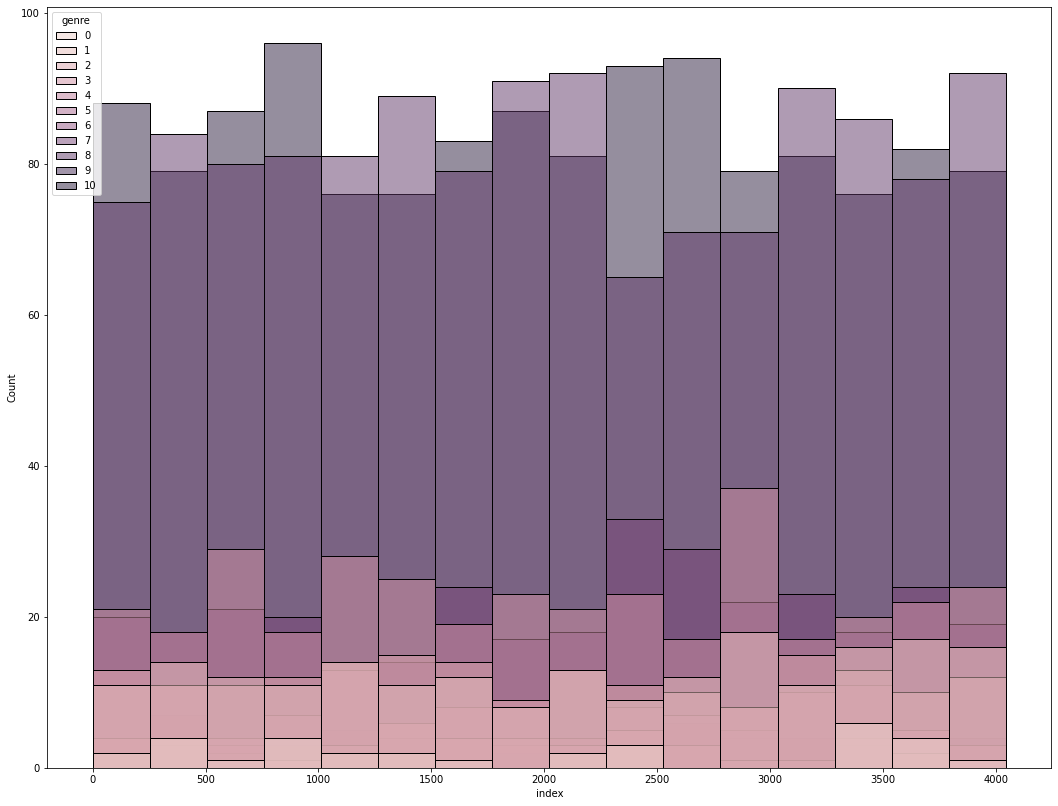

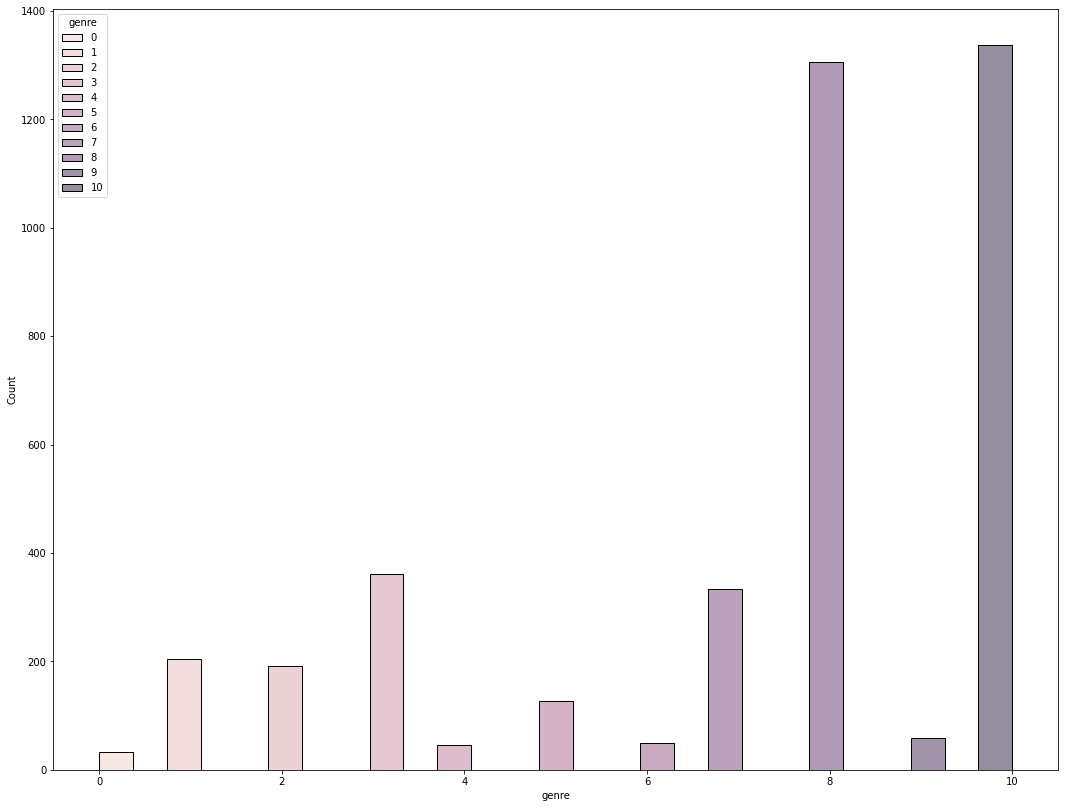

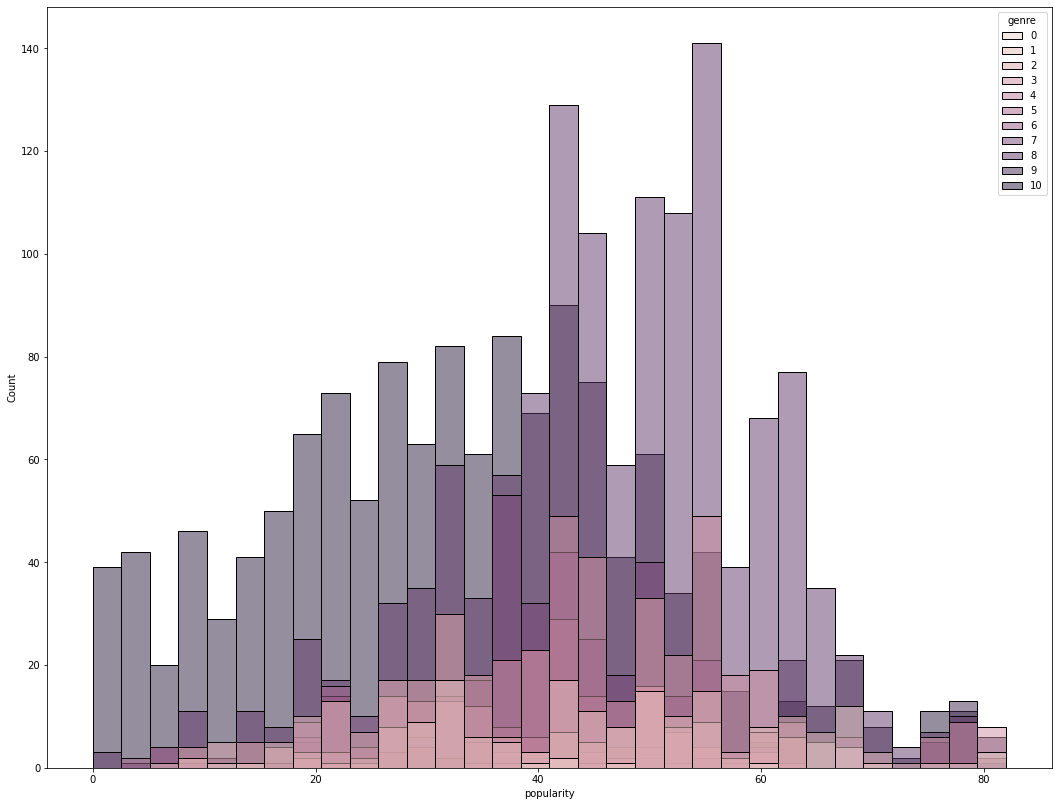

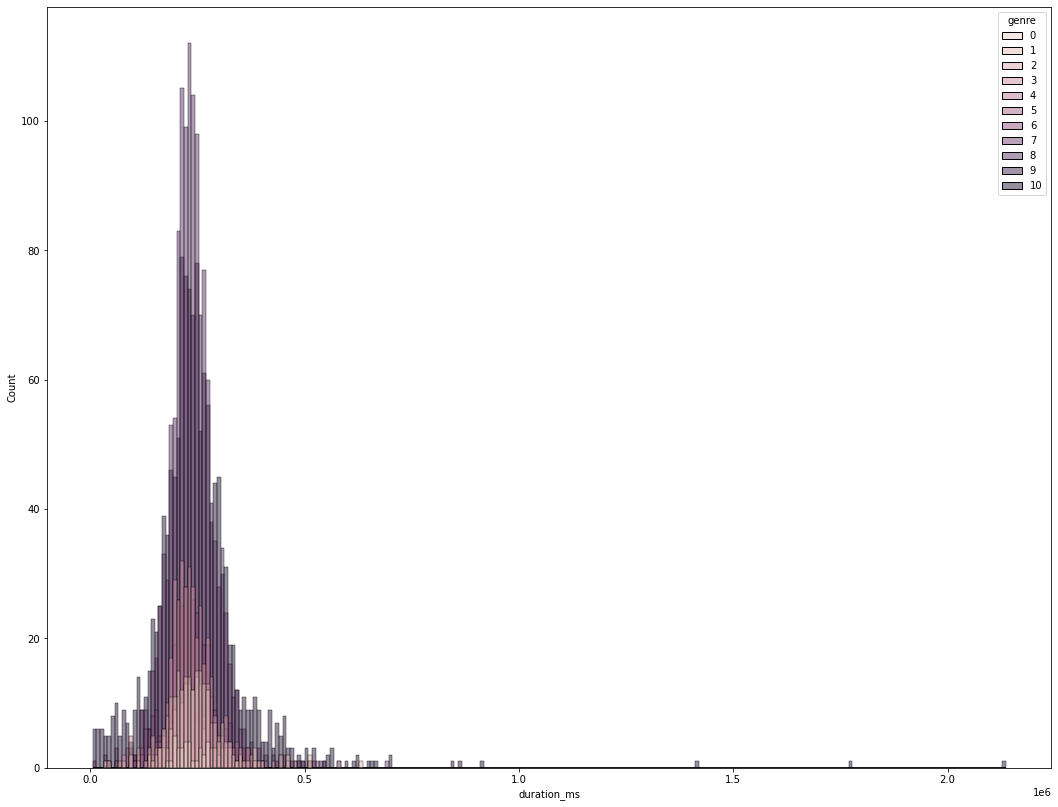

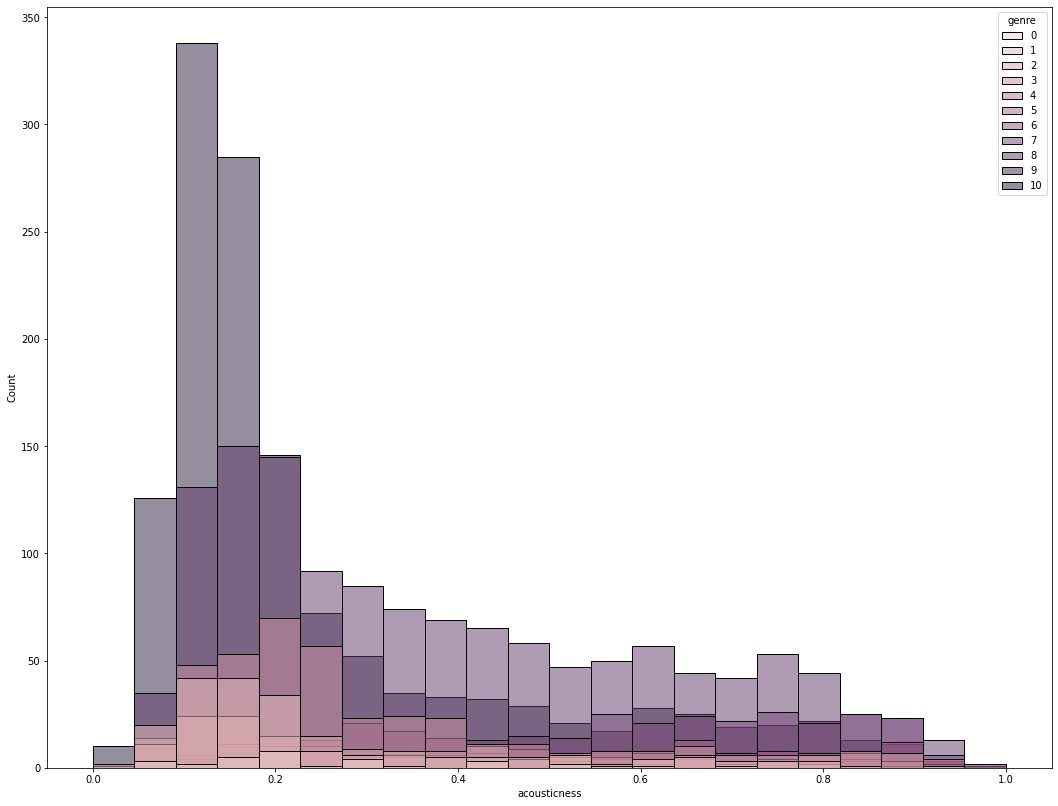

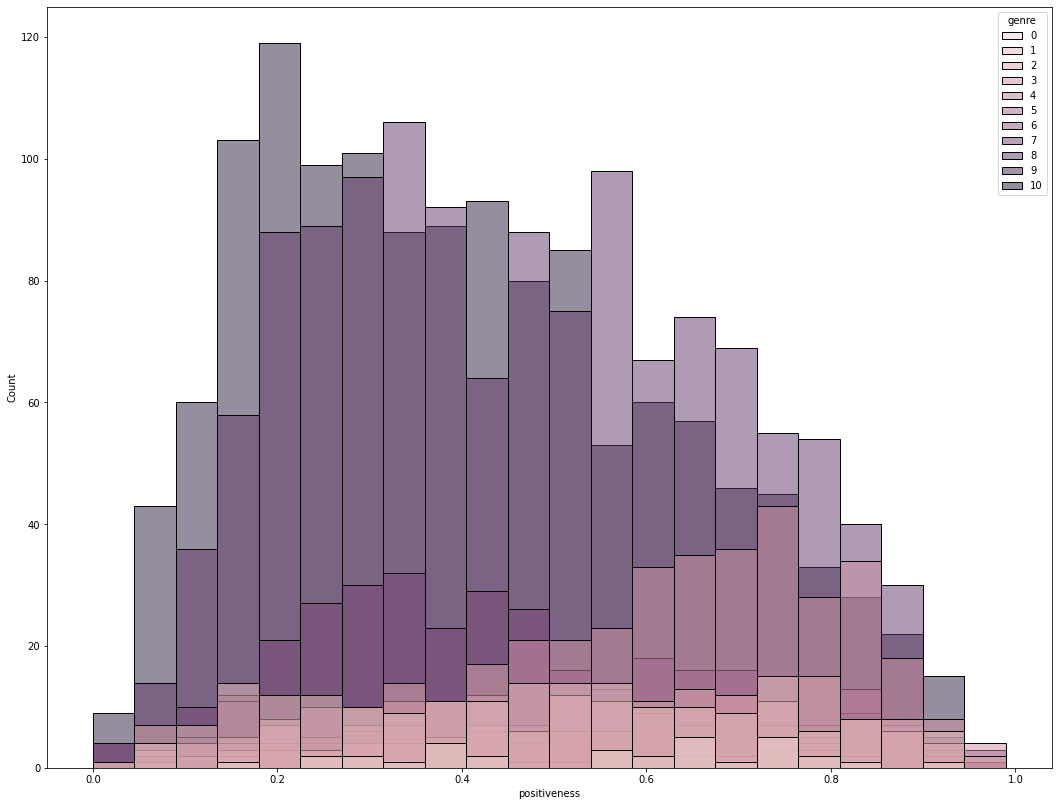

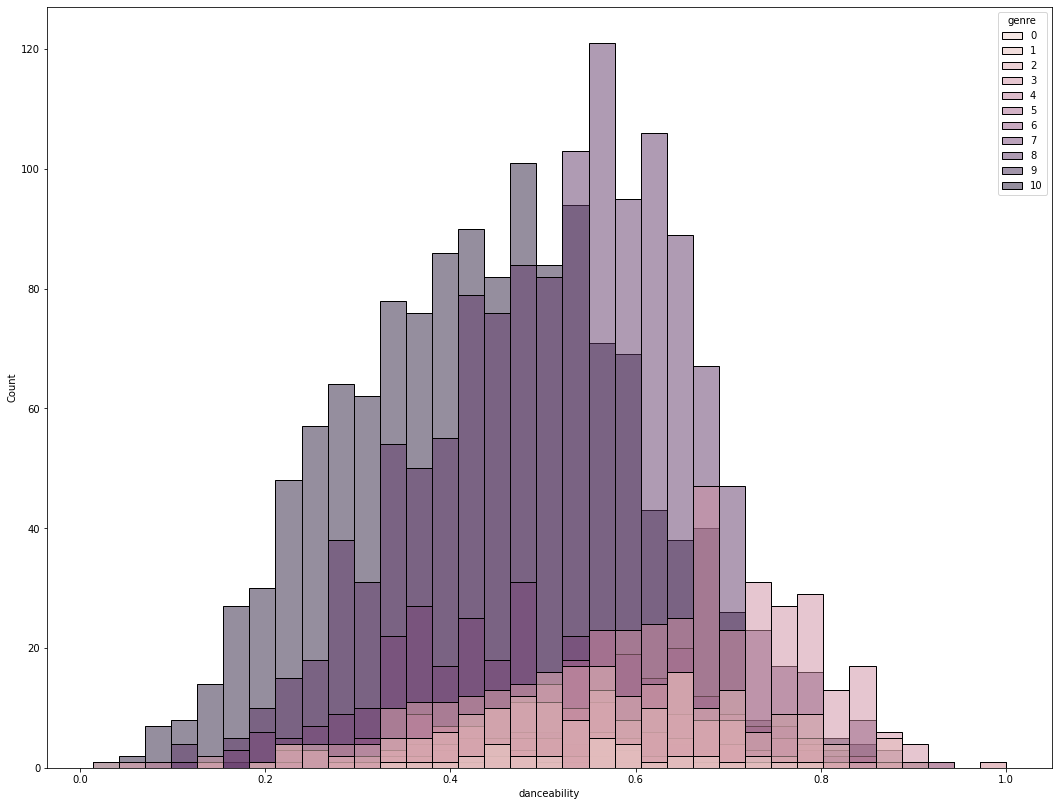

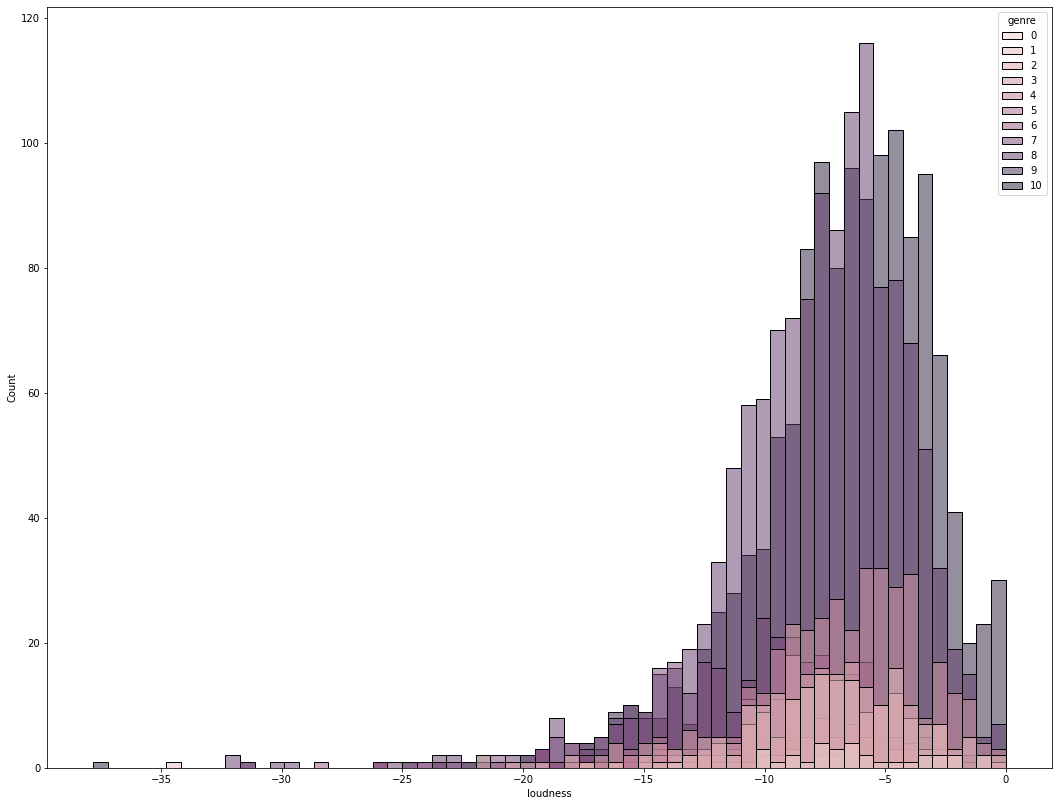

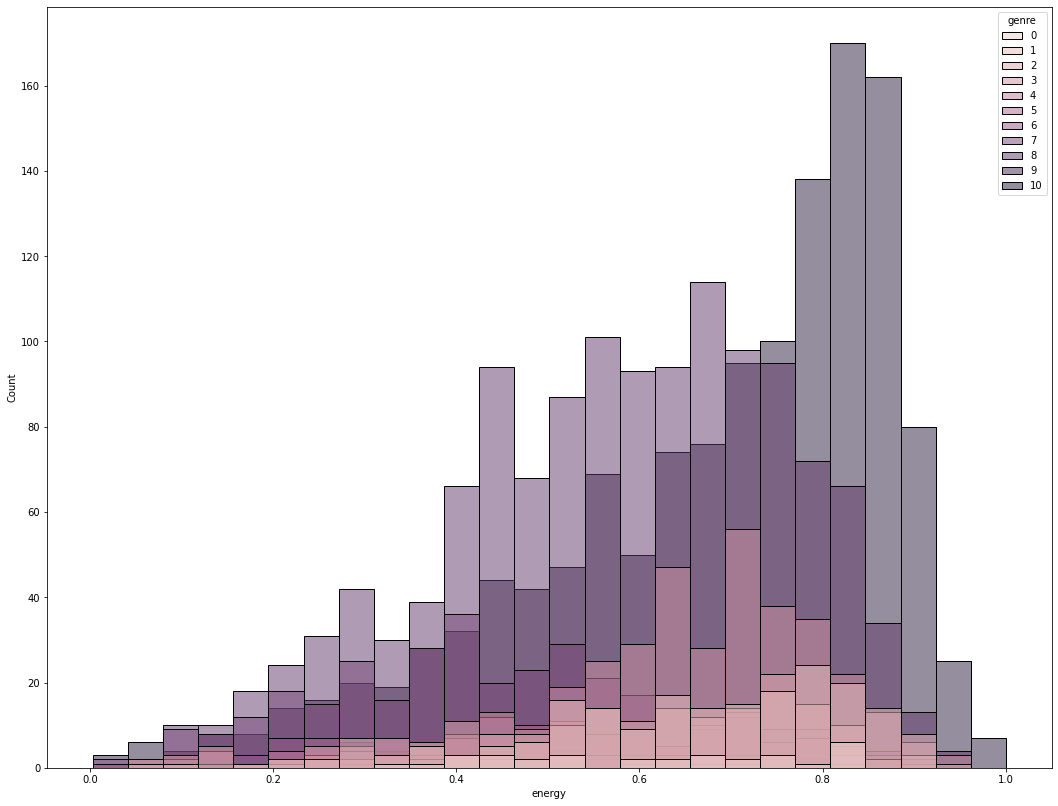

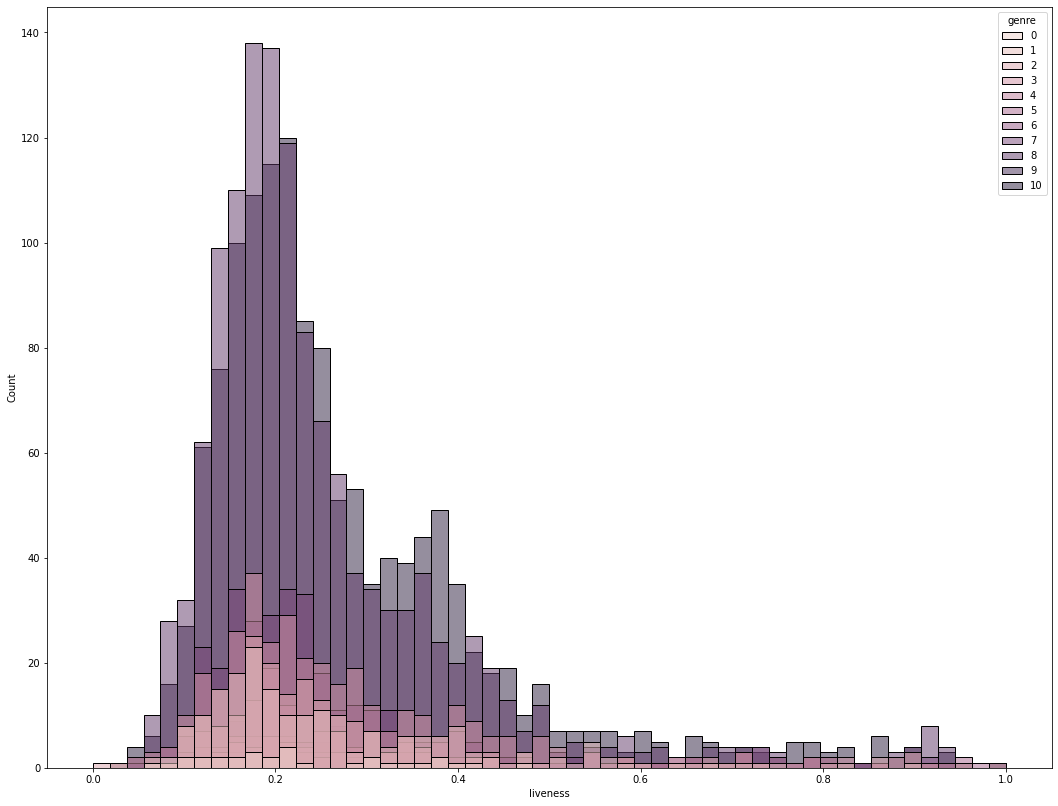

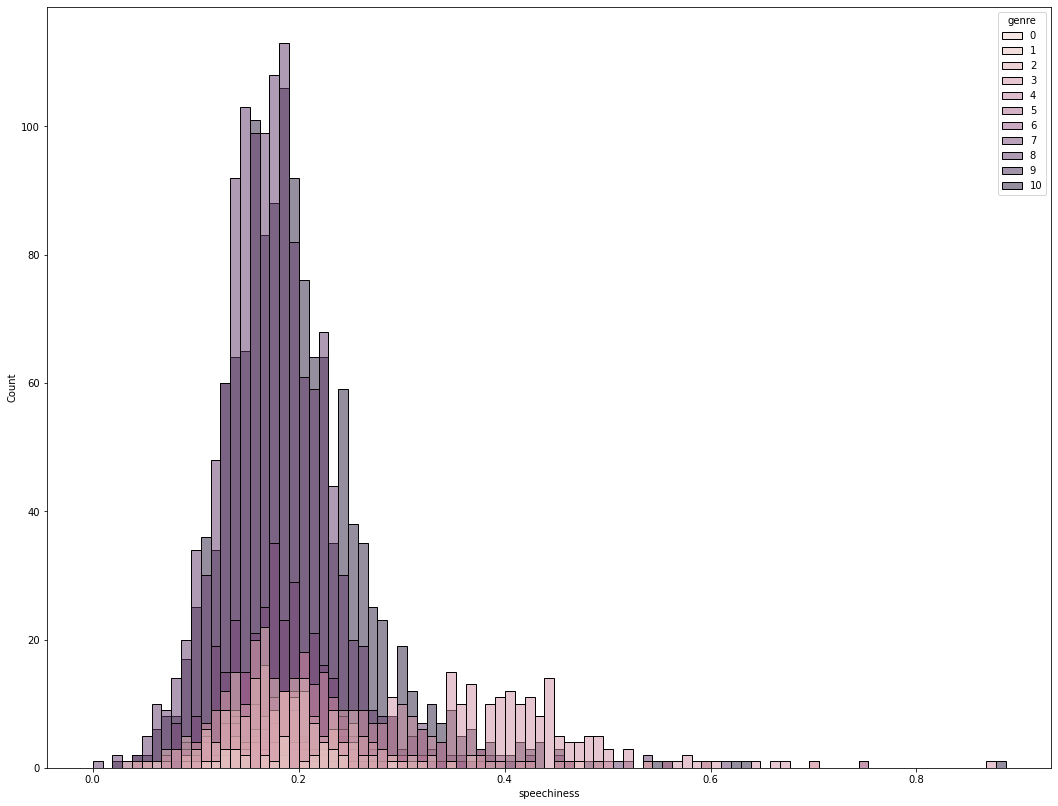

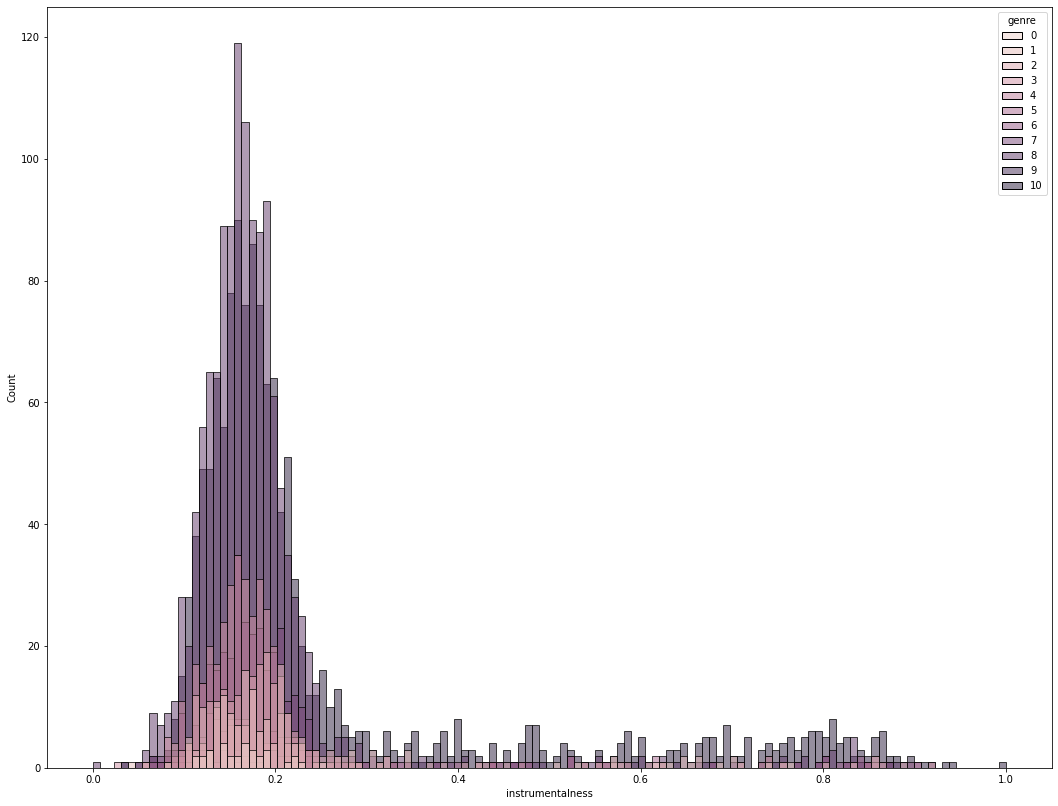

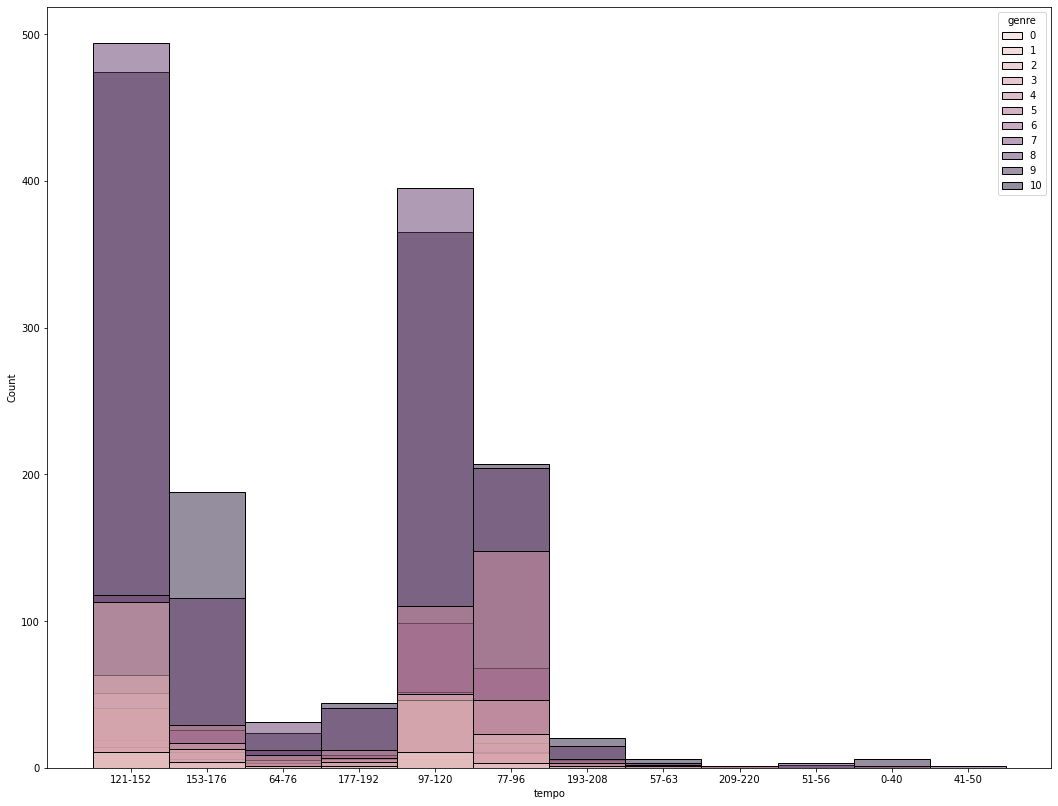

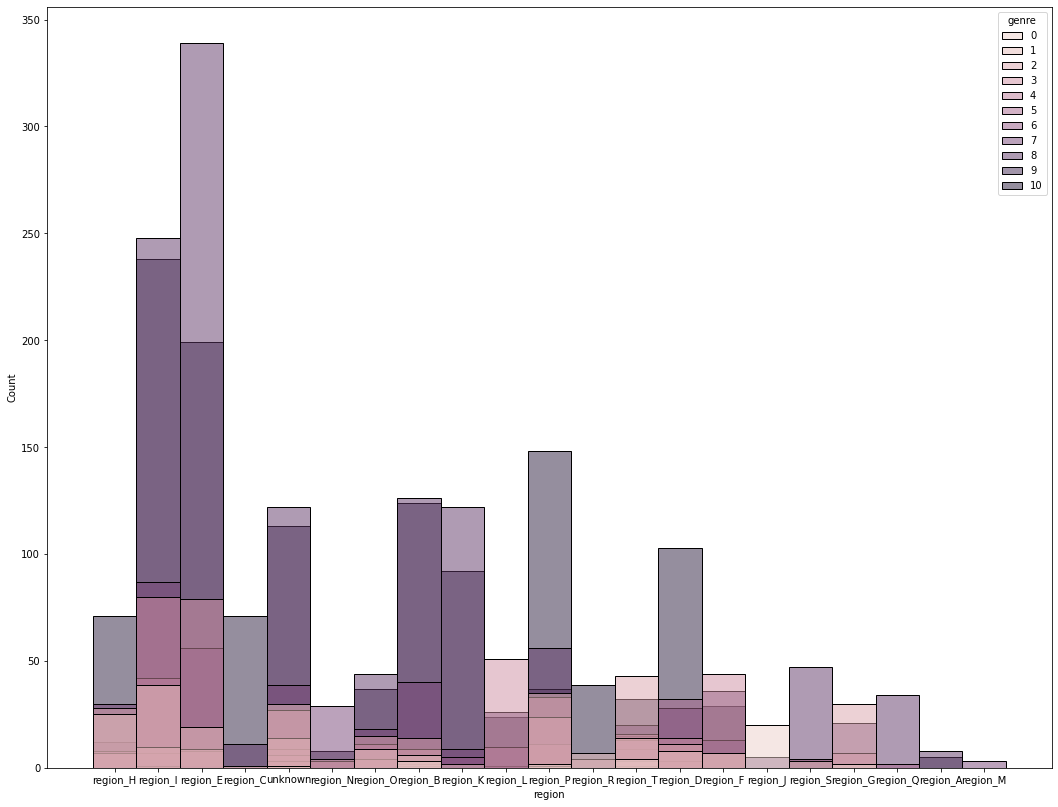

In [26]:
def graph(data, col,target):
    plt.figure(figsize=(18, 14))
    sns.histplot(data=data, x=col, hue=target)
    
for col in train_origin:
    graph(train_origin, col, train_origin['genre'])